# Сегментация пользователей банка по количеству используемых продуктов для влияния на их отток

***Цель проекта*** - выявить возможные особенности разных сегментов клиентов банка для создания УТП для каждого из них и снизить  отток

***Описание проекта***

Банк сделал заказ на аналитику. Главная задача - сегментирование пользователей банка. Сегментация покажет, как клиенты пользуются услугами банка.

***Ход проекта***

Данные находятся по ссылке - /datasets/bank_dataset.csv

Необходимо произвести обзор данных, предобработку, исследовательский анализ данных. Далее произвести сегментацию клиентов, выявить портреты клиентов в каждом из сегментов, расчитать процент оттока. Предложить банковские продукты для каждого из сегментов 

## Обзор данных и предобработка

Импортируем необходимые для работы библиотеки:

In [1]:
# импорт библиотек для работы
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from termcolor import colored
import seaborn as sns
from scipy import stats as st

Добавляем функцию для обзора данных:

In [2]:
# функция для обзора данных в таблице
def view(data, name):
    print(colored('Обзор данных таблицы', 'blue'), name)
    print()
    print('Первые 5 строк данных')
    display(data.head()) # Выводим первые 5 строк
    print()
    print('Информация по таблице')
    display(data.info()) # Выводим инфо по датасету
    print()
    print('Пропуски')
    display(data.isna().sum())
    print()
    print('Количество явных дубликатов:', data.duplicated().sum())
    print()

Сохраняем датасет в переменную и с помощью функции производим обзор данных датасета:

In [3]:
# сохраняем данные в переменную
data = pd.read_csv('/datasets/bank_dataset.csv')

# открываем его с помощью функции
view(data, colored('с данными клиентов банка', 'blue'))

Обзор данных таблицы с данными клиентов банка

Первые 5 строк данных


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0



Информация по таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


None


Пропуски


userid                 0
score                  0
City                   0
Gender                 0
Age                    0
Objects                0
Balance             3617
Products               0
CreditCard             0
Loyalty                0
estimated_salary       0
Churn                  0
dtype: int64


Количество явных дубликатов: 0



Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

Необходимо привести название столбцов к единому регистру. Явных дубликатов нет, однако имеет смысл проверить наличие возможных дубликатов без колонки 'userid'. 

Есть довольно много пропусков в столбце 'Balance', необходимо принять решение по ним. 

Приведем все названия столбцов красивому стилю:

In [4]:
# приводим названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data = data.rename(columns={'userid':'user_id', 'creditcard':'credit_card'})
data.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

Проверим наличие дубликатов без учета столбца с user_id:

In [5]:
# проверим наличие дубликатов без столбца user_id
data.duplicated(subset=['score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn']).sum()

0

Проверим пропущенные значения в столбце с балансом. Возможно есть какие-то закономерности, которые мы сможем увидеть. 
Например, если у таких пользователей нет карты, поэтому и баланс не подтянулся:

In [6]:
# проверяем строки, где есть пропуске в столбце balance
nan_balance = data[data['balance'].isna()]
display(nan_balance.head())
print()
display(nan_balance.describe())

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
11,15779909,497,Рыбинск,М,24,3,NaN,2,1,0,76390.01,0
12,15675000,476,Ярославль,Ж,34,10,NaN,2,1,0,26260.98,0


,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,3.617000e+03,3617.000000,3617.000000,3617.000000,0.0,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000
mean,1.573469e+07,649.452861,38.434891,5.071330,NaN,1.784628,0.716616,0.517832,98983.559549,0.138236
std,7.194749e+04,96.158798,10.492002,2.860781,NaN,0.496455,0.450704,0.499751,57730.828955,0.345195
min,1.560844e+07,350.000000,18.000000,0.000000,NaN,1.000000,0.000000,0.000000,90.070000,0.000000
25%,1.567226e+07,583.000000,31.000000,3.000000,NaN,1.000000,0.000000,0.000000,49506.820000,0.000000
50%,1.573608e+07,651.000000,37.000000,5.000000,NaN,2.000000,1.000000,1.000000,98618.790000,0.000000
75%,1.579629e+07,717.000000,43.000000,7.000000,NaN,2.000000,1.000000,1.000000,148330.970000,0.000000
max,1.585810e+07,850.000000,88.000000,10.000000,NaN,4.000000,1.000000,1.000000,199992.480000,1.000000


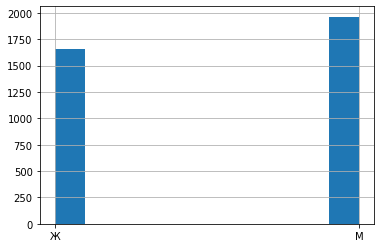

In [7]:
# гистограмма по полу
nan_balance['gender'].hist()
plt.show()

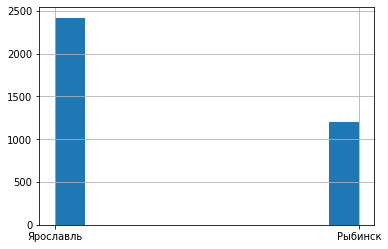

In [8]:
# гистограмма по городам
nan_balance['city'].hist()
plt.show()

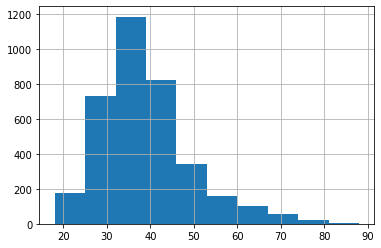

In [9]:
# гистограмма по возрасту
nan_balance['age'].hist()
plt.show()

Большая часть пользователей, у которых отсутствуют данные о балансе не находятся в оттоке. Более того многие используют несколько банковских продуктов. Одним из них у большинства является кредитная карта. 
Пользователи, у которых не указан баланс более менее равномерно распределены по половому признаку. Есть особенность, что баланс не указан только у пользователей из Ярославля и Рыбинка, по Ростову Великому данные представленны полные. 

Средний возраст тех, у кого есть пропуски в данных, примерно на уровне 38. По гистограмме видно, что такие клиенты распределены в основном в возрастном диапазоне от 25 до 45 лет. 

Возможно в данный момент у них нет средств на балансе или это особенности выгрузки. Связать отсутствие значений с какой-либо причиной сложно. 

Проверим какой процент пропущенные значения занимают от общего количества значений в столбце:

In [10]:
# считаем процент пропущенных значений
share_balance = data['balance'].isna().mean()
print(f'{share_balance:.2%}')

36.17%


36% - это очень много. Удалять эти данные абсолютно точно не стоит. Оставим так как есть, однако запомним, что у нас много пропущенных данных в этом столбце. Это может влиять на результаты, которые мы будем получать при построении диаграмм. 

### Вывод

Мы произвели обзор данных. Не выявили дубликаты. В столбце balance было обнаружено достаточное количество пропусков. Предположение о том, что возможно эти клиенты не используют кредитные карты не подтвердилось. Нам не известно особенность ли это выгрузки или у них нет средств на карте, поэтому оставили пропуски не тронутыми (они занимают 36% данного столбца датасета). 
Таже привели названия столбцов к единому стилю. Можно приступать к исследовательскому анализу данных.

## Исследивательский анализ данных

Посмотрим общие данные по таблице, чтобы сформировать общий портрет клиента нашего банка:

In [11]:
# выводим описание
data.describe()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


В среднем клиент нашего банка в возрасте 37-39 лет. Однако видим, что среднее отклонение весьма большое, минимальны возраст - 18 лет, максимальный - 92 года. 

Клиенты банка имеют в среднем 5 объектов в собственности, минимально - 0, максимально - 10. 

Большая часть клиентов использует только 1 продукт банка. Можно предположить, что это кредитная карта, но не обязательно. 

80% датасета - это действующие клиенты, которые на данный момент еще сотрудничают с банком. 

Портрет клиента получается весьма размытым. Попробуем посмотреть есть ли у клиентов в оттоке по отношению к действующим клиентам:

Распределение признаков


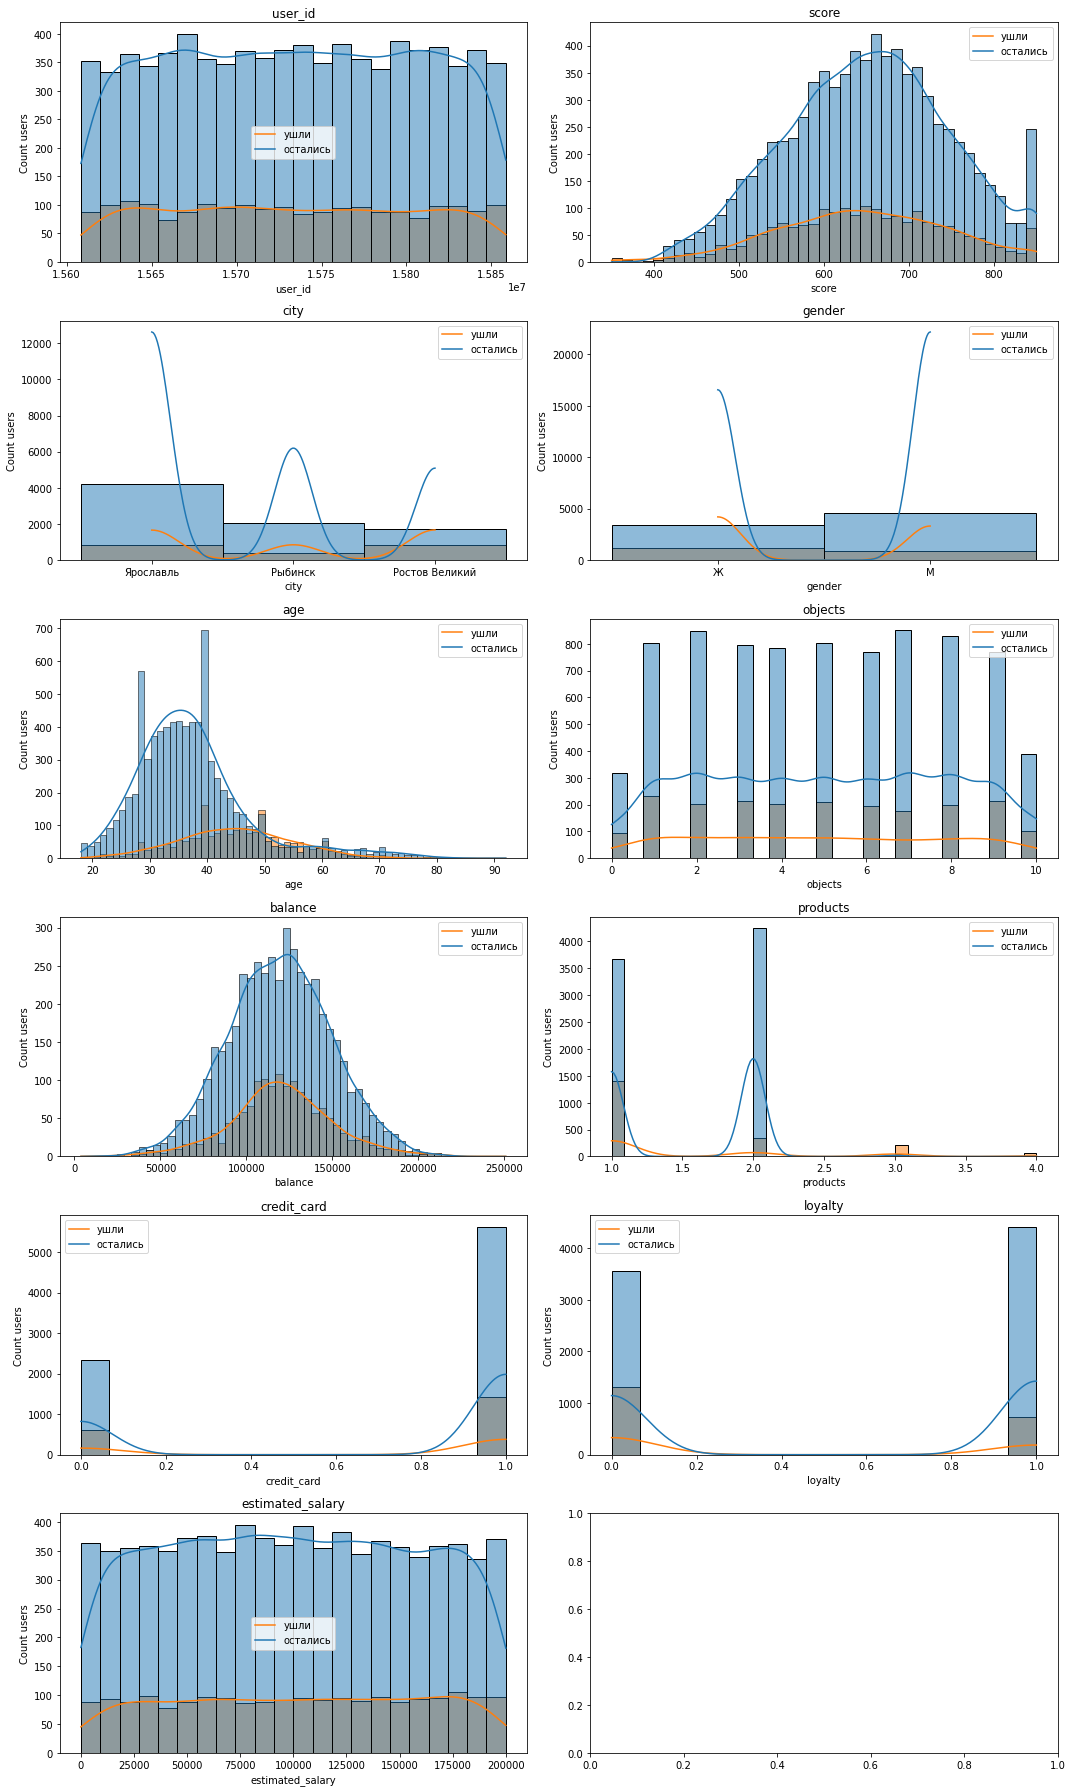

In [12]:
def show(data):
    print(colored('Распределение признаков', 'blue'))
    
    for i in range(len(data.drop('churn', axis=1).columns)):
        sns.histplot(data=data, x=data[data.columns[i]], hue='churn', ax=ax[i], kde=True)
        ax[i].set_title(f'{data.columns[i]}')
        ax[i].set_ylabel('Count users')
        ax[i].legend(['ушли', 'остались'])


    fig.tight_layout()
    fig.show()

    
# строим диаграммы 
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(15, 25))
ax = ax.flatten()    
show(data)    

Исходя из данных мы можем видеть дополнительные момент к общему портрету клиента банка - большая часть клиентов из Ярославля. Мужчин в клиентах немного больше, чем женщин. 

Для анализа портретов действующих клиентов и клиентов в оттоке посмотрим еще медианные значения всех показателей в каждой из этих групп:

In [13]:
# группираем данные, смотрим медианные значения признаков для клиентов в оттоке и действующих клиентов
data.groupby('churn').median()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary
churn,,,,,,,,,
0,15734279,653,36,5,119791.215,2,1,1,99645.04
1,15731699,646,45,5,119948.090,1,1,0,102460.84


Смотрим именно медианные значения, чтобы не было перекосов в сторону выбросов. 

Что мы видим. Действующие клиенты:
- обычно младше по возрасту
- пользуются большим количеством продуктов, чем клиенты в оттоке
- больше всего их в Ярославле
- чаще мужчины

Клиенты в оттоке:
- обычно старше
- использовали лишь один продукт
- их заработная плата немного больше
- больше всего в Ростов Великий
- чаще женщины, чем мужчины

### Вывод

Конечно, общий портрет клиента банка у нас получается довольно размытым:
- в среднем клиентам 37-39 лет, минимальный возраст - 18, максимальный - 92
- в среднем клиенты банка имеют 5 объектов в собственности, минимально - 0, максимально - 10
- большая часть клиентов банка использует 1 продукт, часто это кредитная карта
- 80% датасета - действующие клиенты, 20% - отток
- большая часть клиентов банка из Ярославля
- немного чаще услугами банка пользуются мужчины, чем женщины

Действующие клиенты:
- обычно младше по возрасту (в среднем на 10 лет)
- пользуются большим количеством продуктов (обычно 2мя)
- больше всего их в Ярославле
- чаще мужчины

Клиенты в оттоке:
- обычно старше
- используют только один продукт
- больше всего в Ростове Великом
- чаще женщины, чем мужчины

Это весьма общие данные на обсновании средних и медианных значений датасета. Необходимо разделить клиентов на сегменты исходя из количества используемых продуктов и рассмотреть портреты клиентов банка действующих и в оттоке более подробно. 

Исходя из данных мы видим, что максимально клиенты используют 4 продукта банка. Соответственно разделим всех клиентов на 4 сегмента. Посмотрим, какими характеристиками обладают клиенты разных сегментов. 

## Сегментация клиентов по количеству используемых продуктов

Сгруппируем данные по количеству продуктов, чтобы у нас получились 4 сегмента:

In [15]:
data.groupby('products')['user_id'].count().reset_index()

,products,user_id
0,1,5084
1,2,4590
2,3,266
3,4,60


Получается, что сегменты клиентов, которые используют более 2х продуктов совсем не большие. 
Посмотрим медианные значения по каждому из сегментов:

In [16]:
# группируем данные по количеству продуктов
data.groupby('products').median()

,user_id,score,age,objects,balance,credit_card,loyalty,estimated_salary,churn
products,,,,,,,,,
1,15732061.0,651.0,38.0,5.0,119919.120,1.0,1.0,99226.830,0.0
2,15735775.5,653.0,36.0,5.0,119762.245,1.0,1.0,100738.855,0.0
3,15744380.5,650.0,42.0,5.0,118118.190,1.0,0.0,101046.885,1.0
4,15707754.5,643.0,45.0,5.0,120968.270,1.0,0.0,112163.105,1.0


В основном разница видна в возрасте клиентов, есть небольшая разница в доходе. Видно, что сегменты, использующие один или два продукта, действующие клиенты банка, а сегменты, которые использовали 3 или 4 пролукта, находятся в оттоке. 

Посмотрим данные на диаграммах:

Сегмент 1
Распределение признаков


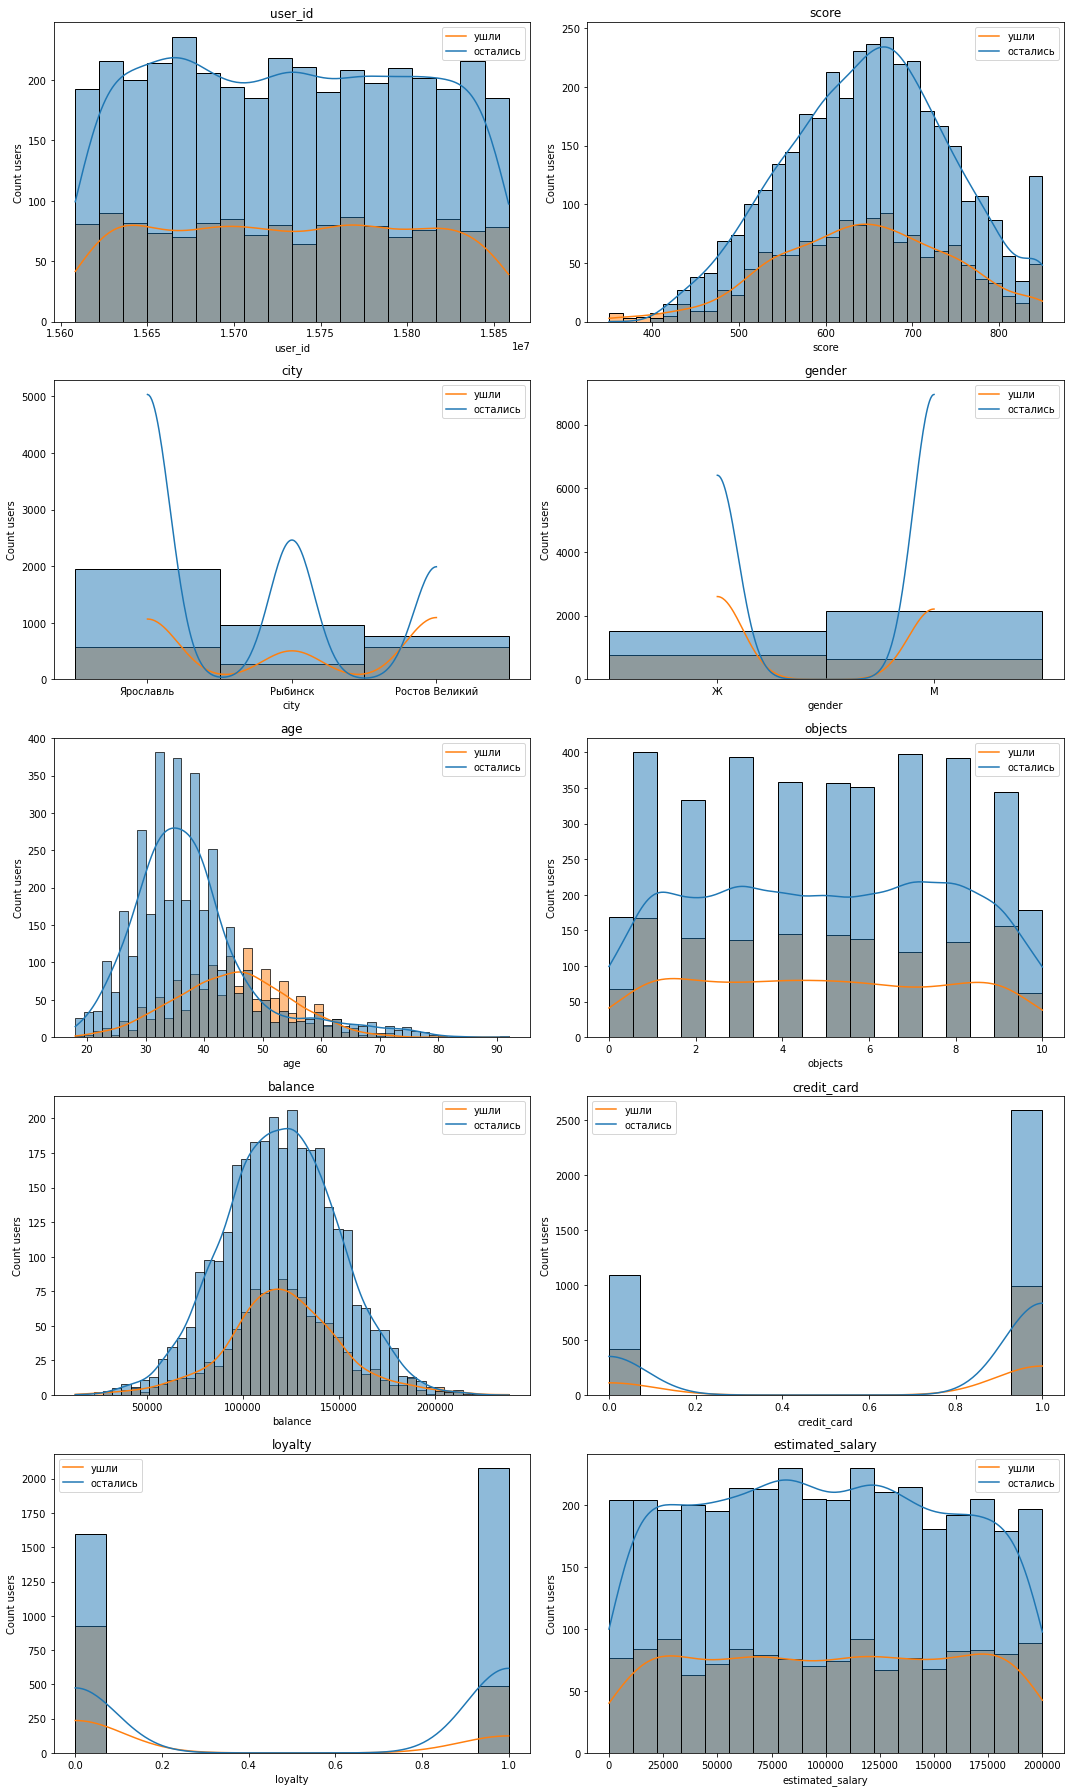

In [17]:
# выделяем сегмент
segment = data[data['products'] == 1]
segment = segment.drop('products', axis=1)

# строим диаграммы 
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))
ax = ax.flatten()

print('Сегмент 1')
show(segment)

Сегмент 1:
- основная часть действующих клиентов из Ярославля, больший отток идет из Ростова Великого
- мужчин чуть больше, чем женщин. В отток уходят чуть чаще женщины, чем мужчины
- распределение баланса на счету примерно одно у оттока и не оттока
- большая часть клиентов использует кредитные карты
- средний возраст - 38 лет. по распределению видно, что клиенты в оттоке по сегменту обычно старше, чем действующие
- заработная плата распределена равномерно

Сегмент 2
Распределение признаков


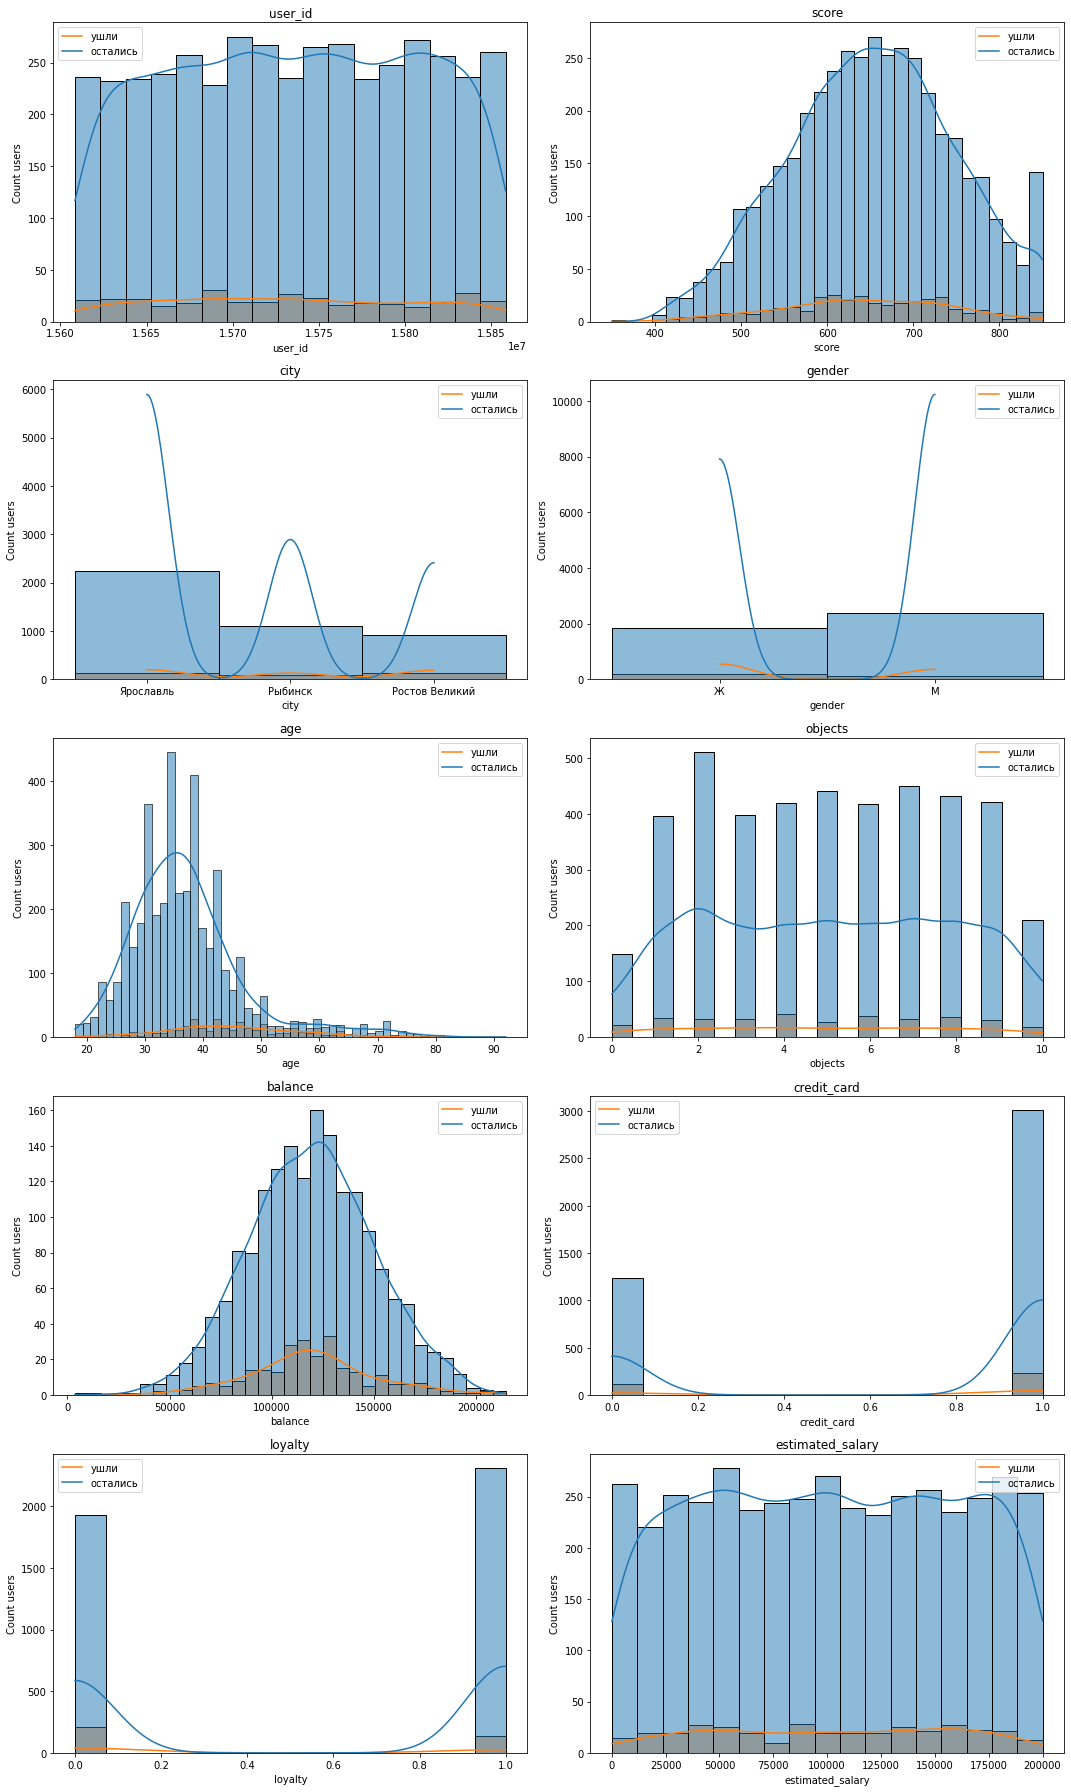

In [18]:
# выделяем сегмент
segment_2 = data[data['products'] == 2]
segment_2 = segment_2.drop('products', axis=1)

# строим диаграммы 
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))
ax = ax.flatten()

print('Сегмент 2')
show(segment_2)

Сегмент 2:
- видно, что клиентов в оттоке меньше всего
- основная часть клиентов из Ярославля, но отток равномерно идет по всем городам
- мужчин больше, чем женщин. Отток распределен равномерно между полами
- средний возраст - 36. Клиенты в оттоке равномерно распределены, но обычно более старшего возраста
- распределение средств на балансе примерно одно у оттока и не оттока + в среднем количество средств примерно одинаково с первым сегментом
- большая часть клиентов используют кредитные карты
- заработная плата равномерно распределена среди клиентов в оттоке и действующих

Сегмент 3
Распределение признаков


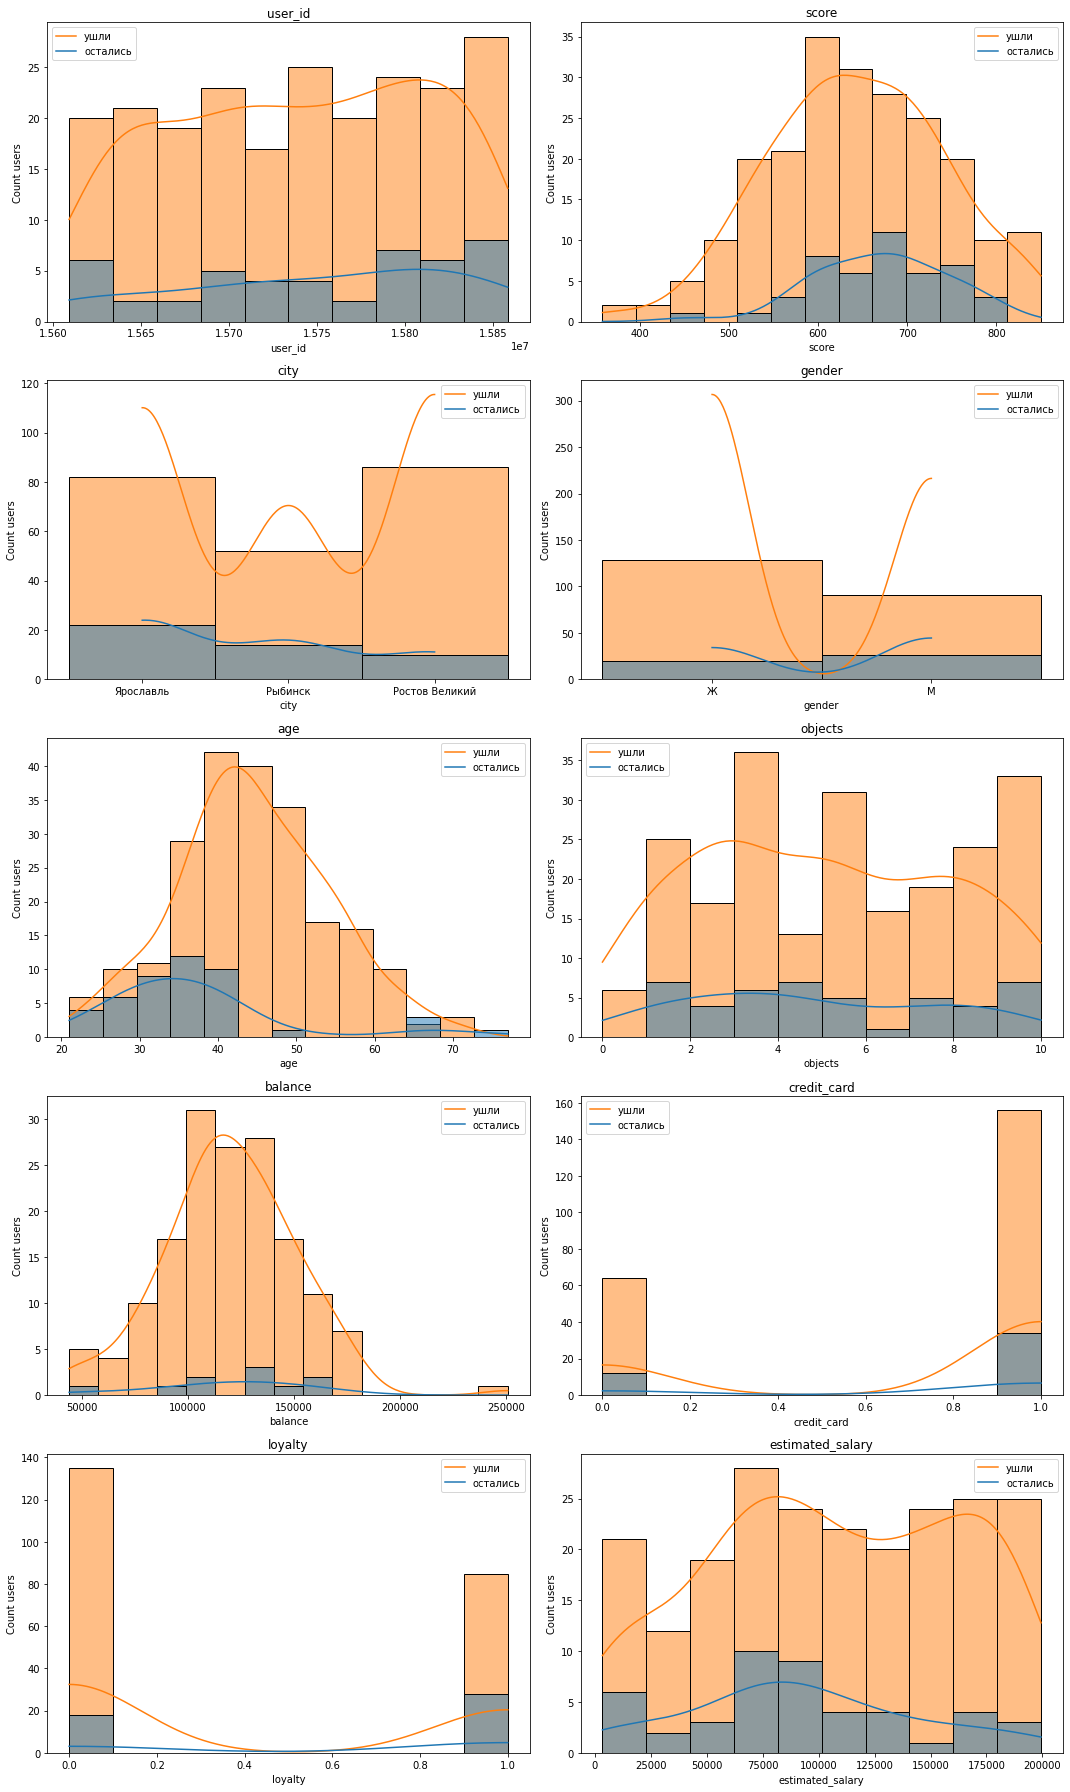

In [19]:
# выделяем сегмент
segment_3 = data[data['products'] == 3]
segment_3 = segment_3.drop('products', axis=1)

# строим диаграммы 
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))
ax = ax.flatten()

print('Сегмент 3')
show(segment_3)

Сегмент 3:
- очень высокий процент оттока клиентов
- больше всего клиентов из Ростова Великого, Ярославль чуть отстает
- больше всего действующих клиентов из Ярославля, максимальный отток по клиентам в Ростове
- женщин больше, чем мужчин, но мужчины меньше оттекают
- в среднем клиенты старше - 42 года, большой отток клиентов именно в пределах от 40 до 60 лет
- баланс в среднем у клиентов этого сегмента немного меньше

Сегмент 4
Распределение признаков


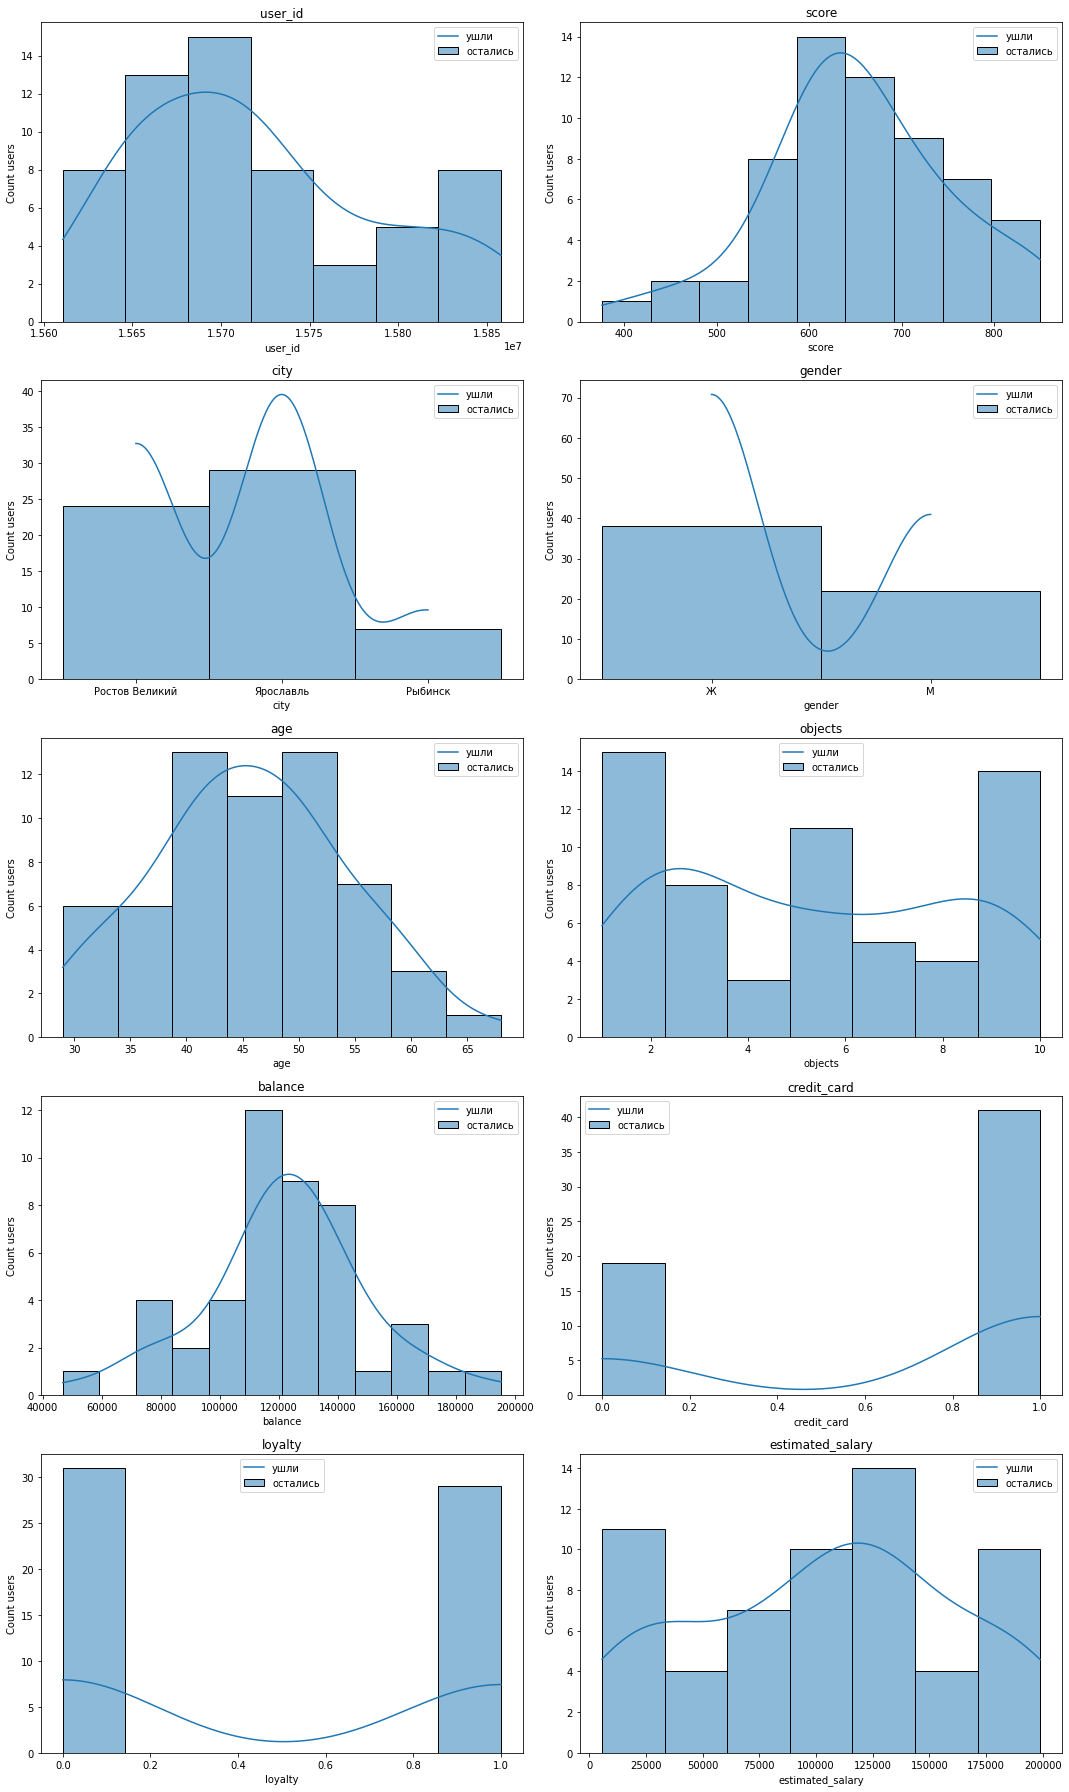

In [20]:
# выделяем сегмент
segment_4 = data[data['products'] == 4]
segment_4 = segment_4.drop('products', axis=1)

# строим диаграммы 
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))
ax = ax.flatten()

print('Сегмент 4')
show(segment_4)

Сегмент 4:
- в этом сегменте все клиенты попали в отток
- больше всего клиентов из Ярославля, на втором месте Ростов Великий
- женщин сильно больше, чем мужчин
- по возрасту - самый возрастной сегмент, средний возраст - 45 лет 
- баланс на карте у них в среднем немного больше, чем у других сегментов
- довольно много клиентов не использует кредитные карты


Проверим процент оттока по каждому из сегментов:

Доля оттока по каждому сегменту


products,1,2,3,4
churn,0.277144,0.075817,0.827068,1.0


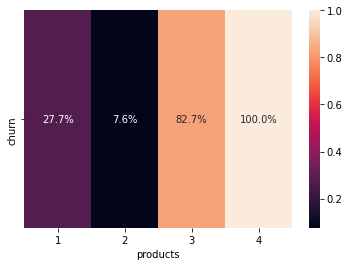

In [21]:
# строим данные оттока по кластеру
print(colored('Доля оттока по каждому сегменту', 'blue'))
churn = data.groupby('products').agg({'churn':'mean'}).T
display(churn)


sns.heatmap(churn, annot=True,
            fmt='.1%',)
plt.show()

Больше всего оттока в третьем и четвертов сегментах. Самый низкий отток в сегменте, в котором пользователи используют 2 продукта. 

### Вывод

В рамках исследовательского анализа мы выявили, что клиенты банка используют от одного до четырех продуктов. Логично разделить их на 4 сегмента в зависимости от количества используемых продуктов. 

В первые два сегмента у нас вошло больше всего пользователей. Эти сегменты весьма схожи между собой - по возрату, городу проживания, данным о балансе. Однако в сегменте, где клиенты используют 2 продукта, вместо одного, отток гораздо ниже. Можно предположить, что количество продуктов влияет на этот отток. 
Однако стоит проверить отличаются ли статистически доходы клиентов данных сегментов, количество объектов в собственности у данных клиентов. Они могут влиять на конечный результат - меньший отток. 

Два последних сегмента - клиенты, которые используют 3 и 4 продукта соответственно, - показывают наибольший процент оттока. 
В этих сегментах больше женщин, чем мужчин, возраст клиентов больше, больше клиентов из Ростова Великого. Необходимо рассмотреть данные сегменты и предложить для них банковский продукт, который позволит увеличить их удержание. 

## Проверка гипотез

Итак, проверим две гипотезы относительно сегментов с одним и двумя продуктами. 

Первая гипотеза:

Н0 - средняя заработная плата в сегментах клиентов, которые используют только один продукт, и тех, кто использует два продукта, равна

Н1 - средняя заработная плата в сегментах клиентов, которые используют только один продукт, и тех, кто использует два продукта, отличается

Возьмем критический уровень значимости на уровне 1%, так как нам важно как можно точнее понимать, что данный признак не влияет различие в уровне оттока между двумя сегментами. 

In [22]:
# т-тест для проверки гипотезы о том, что заработная плата сегментов с одним и двумя продуктами равна
sample_1 = segment['estimated_salary']
sample_2 = segment_2['estimated_salary']
results = st.ttest_ind(sample_1, sample_2)
alpha = 0.01

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.41047183624949335
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть гипотезу о том, что средняя заработная плата по сегментам равна. Ранее мы видели, что небольшие различия в заработной плате есть, но различия не превзошли уровень критической значимости. 

Теперь посмотрим данные по количеству объектов в собственности.

Вторая гипотеза:

Н0 - среднее количество объектов в собственности у сегментов клиентов с одним используемым продуктом и двумя равно 

Н1 - среднее количество объектов в собственности у сегментов клиентов с одним используемым продуктом и двумя отличается

Уровень критической значимости возьмем также в 1%. 

In [23]:
# т-тест для проверки гипотезы о том, что количество объектов в собственности у сегментов с одним и двумя продуктами равна
sample_1 = segment['objects']
sample_2 = segment_2['objects']
results = st.ttest_ind(sample_1, sample_2)
alpha = 0.01

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.18976324535670458
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть, что количество объектов в собственности между сегментами равно. Мы ранее видили в данных небольшую разницу, однако она не оказалась статистически значимой. 

### Вывод

Мы проверили две гипотезы:
- что доход между первыми двумя сегментами различается
- что количество объектов в собственности по сегментам различается

Это было важно, поскольку после исследования разных сегментов, мы заметили, что сегменты с одним продуктом и двумя очень похожи по характеристикам. Соответственно мы можем преположить, что лучшие показатели удержания во втором сегменте (клиенты с двумя продуктами) связаны именно с количеством используемых банковских продуктов. 

Гипотезы не подтвердились - не получилось отвергуть, что доход и количество объектов в собственности, одинаковое в двух сегментах. 

Исходя из этого мы можем рекомендовать предлагать дополнительный продукт для текущих клиентов - это уменьшает их отток

## Общий вывод

В ходе исследования получили портрет среднего клиента банка. Чаще услугами банка пользуются клиенты в среднем 37-39 лет, чаще мужчины, чем женщины, большая их часть из Ярославля. Большая часть клиентов банка используют кредитные карты, и часто это их единственный продукт, которым они пользуются. 

Действующие клиенты банка обычно используют больше продуктов, младше по возрасту, мужчины и чаще из Ярославля, клиенты в оттоке - используют один продукт, старше по возрасту, женщины, чаще из Ростова Великого. 

Эти данные очень общие. Клиенты банка используют от одного до четырех продуктов. Было принято решение разделить клиентов на 4 сегмента и оценить портрет клиента в каждом из сегментов: действующего и отточного. 

Сегменты клиентов пользующиеся одним и двумя продуктами получились весьма одинаковые: 36-38 лет, чаще мужчины, чем женщины, больше клиентов из Ярославля, чем из других городов. Основное отличие - количество продуктов и процент оттока. 
Мы предположили, что данные по их заработной плате и количеству объектов в собственности может отличаться. Для проверки гипотез провели статистические тесты - они не показали статистической разницы между данными признаками сегментов. 

В сегментах тех, кто использует три и четыре продукта, очень высокий процент оттока. В сегменте 4 - процент оттока 100%. В данных сегментах больше средний возраст - 42 для сегмента 3 и 45 для сегмента 4. В данных сегментах больше женщин, чем мужчин и больше клиентов из Ростова Великого.

Данные сегменты малочисленные, но при этом самые отточные. Имеет смысл проработать продукты специально для них. 

Исходя из данных можем рекомендовать:
- для сегмента 1 - предлагать клиентам дополнительные продукты. В связи с тем, что в данный сегмент попадает больше молодых клиентов, то имеет смысл делать упор на предложения ипотеки, кредита на покупку автомобилей. Хотя клиенты распределены по количеству объектов собственности от 0 до 10 примерно равномерно, однако в этом сегменте больше тех, у кого в собственности только 1 объект, и меньше доля тех у кого в собственности их 10. В целом имеет смысл предлагать любые дополнительные продукты, поскольку уже тот факт, что клиент пользуется не одним, а двумя продуктами банка снижает отток
- для сегмента 2 - в данном сегменте самый низкий уровень оттока. По общим данным сложно выделить какие-то особенности клиентов в оттоке по данному сегменту, например, в сравнении с отточными клиентами сегмента 1. Имеет смысл обогатить данные дополнительной информацией: какими продуктами пользуются, род деятельности, наличие детей и т.д, чтобы предоставить более конкретные рекомендации
- для сегмента 3 - в данном сегменте весьма много женщин, среднего возраста, весьма много клиентов из Ростова Великого. В данном сегменте имеет смысл развивать продукты для женщин (у них во всех сегментах большой процент оттока). Например, можно предлагать кредит на учебу детей или кредиты на развитие женщин-предпринимателей. Опять же нужно больше данных о наличии детей и их возраста, рода деятельности клиентов в этом сегменте, чтобы точно сказать какие рекомендации можно дать по клиентам этого сегмента
- для сегмента 4 - в этом сегменте самый высокий средний возврат. Имеет смысл рекомендовать услуги страхования или пенсионные проекты для этих клиентов. Вероятно, что они завершаю выплаты по кредитам\ипотекам, перестают использовать зарплатные карты и переходят в банки с удачными пенсионными проектами

В целом для более точных по сегментам необходимо обогатить данные и произвести анализ сегментов по отдельности.

Материалы (презентация) - https://disk.yandex.ru/i/Z0V3rGUcKiSesQ